In [ ]:
# import necessary packages
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
# set random seed to ensure reproducibility
np.random.seed(8)

# Sample kernel

In [ ]:
# define a kernel function to return a squared exponential distance 
def kernel(x):
    return np.exp(-x**2)

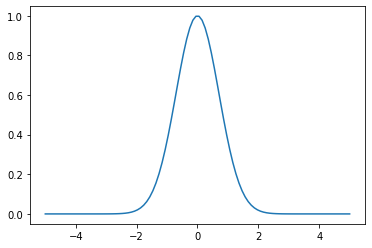

In [ ]:
# create a list of differences between two input locations
X = np.linspace(-5,5,100).reshape(-1,1)
K = kernel(X)
plt.plot(X, K)

# Drawing from the prior distribution

In [ ]:
# define a kernel function to return a squared exponential distance between two input locations
def kernel(a, b):
    # decomposing the squaring operation into three parts
    # each input location may be multi-dimensional, thus summing over all dimensions
    sq_dist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a,b.T)
    return np.exp(-sq_dist)

In [ ]:
# setting number of input locations which approximates a function when growing to infinity
n = 100
X_test = np.linspace(-5,5,n).reshape(-1,1)
# calculate the pairwise distance, resulting in a nxn matrix
K = kernel(X_test, X_test)

In [ ]:
diffs = (X_test - X_test.reshape(1,100)).reshape(-1,1)
K_ = K.reshape(-1,1)

In [ ]:
K_.shape

(10000, 1)

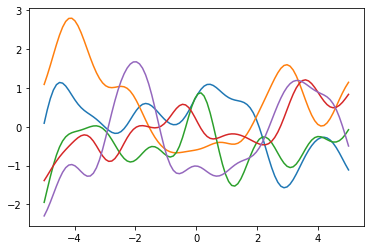

In [ ]:
# adding a small number along diagonal elements to ensure cholesky decomposition works
L = np.linalg.cholesky(K + 1e-10*np.eye(n))
# calculating functional samples by multiplying the sd with standard normal samples
samples = np.dot(L,np.random.normal(size=(n,5)))
plt.plot(X_test, samples)

In [ ]:
# Isotropic squared exponential kernel.
# Args:
#     X1: array of m points (m x d).
#     X2: array of n points (n x d).
# Returns:
#     (m x n) matrix.
def ise_kernel(X1, X2, l=1.0, sigma_f=1.0):
    sq_dist = np.sum(X1**2,1).reshape(-1,1) + np.sum(X2**2,1) - 2*np.dot(X1,X2.T)
    return sigma_f**2 * np.exp(-0.5/l**2 * sq_dist)

In [ ]:
# mean and covariance of the prior
mu = np.zeros(X_test.shape)
K = ise_kernel(X_test, X_test)

In [ ]:
# draw samples from the prior using multivariate_normal from numpy
# convert mu from shape (n,1) to (n,)
samples = np.random.multivariate_normal(mean=mu.ravel(), cov=K, size=5)

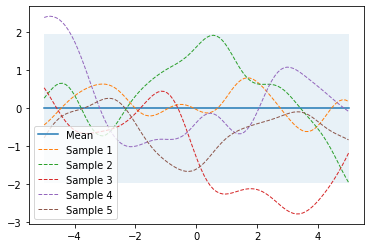

In [ ]:
# plot GP mean, uncertainty region and samples 
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    # 95% confidence interval
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    # plot observations if available
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

plot_gp(mu, K, X_test, samples=samples)

# Obtaining GP posterior with noise-free observations

In [ ]:
from numpy.linalg import inv

def update_posterior(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    """
    Computes the mean vector and covariance matrix of the posterior distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Observation noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    # covariance matrix for observed inputs
    K = ise_kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    # cross-variance between observed and new inputs
    K_s = ise_kernel(X_train, X_s, l, sigma_f)
    # covariance matrix for new inputs
    K_ss = ise_kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    # computer inverse of covariance matrix
    K_inv = inv(K)
    # posterior mean vector based on derived closed-form formula
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    # posterior covariance matrix based on derived closed-form formula
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

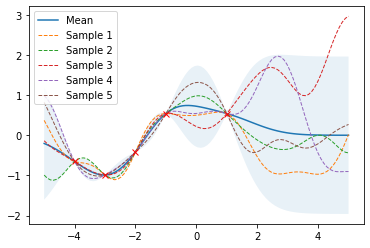

In [ ]:
# noise free training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.cos(X_train)
# compute mean and covariance of the posterior distribution
mu_s, cov_s = update_posterior(X_test, X_train, Y_train)
# generate five samples from multivariate normal distribution
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 5)

plot_gp(mu_s, cov_s, X_test, X_train=X_train, Y_train=Y_train, samples=samples)

# Obtaining GP posterior with noisy observations

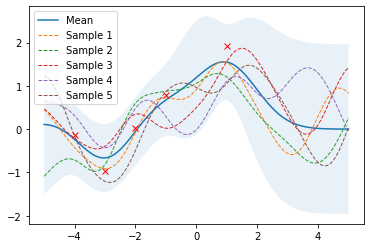

In [ ]:
# set standard deviation of the noise
noise = 0.5
# create noisy training data
Y_train = np.cos(X_train) + noise * np.random.randn(*X_train.shape)
# compute mean and covariance of the posterior distribution
mu_s, cov_s = update_posterior(X_test, X_train, Y_train, sigma_y=noise)
# generate five samples
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 5)

plot_gp(mu_s, cov_s, X_test, X_train=X_train, Y_train=Y_train, samples=samples)

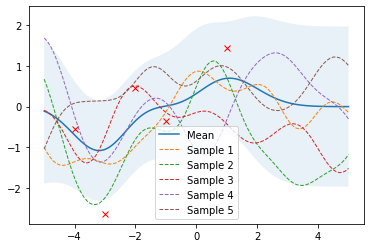

In [ ]:
# set standard deviation of the noise
noise = 1
# create noisy training data
Y_train = np.cos(X_train) + noise * np.random.randn(*X_train.shape)
# compute mean and covariance of the posterior distribution
mu_s, cov_s = update_posterior(X_test, X_train, Y_train, sigma_y=noise)
# generate five samples
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 5)

plot_gp(mu_s, cov_s, X_test, X_train=X_train, Y_train=Y_train, samples=samples)

# Experimenting with differnet kernel parameters

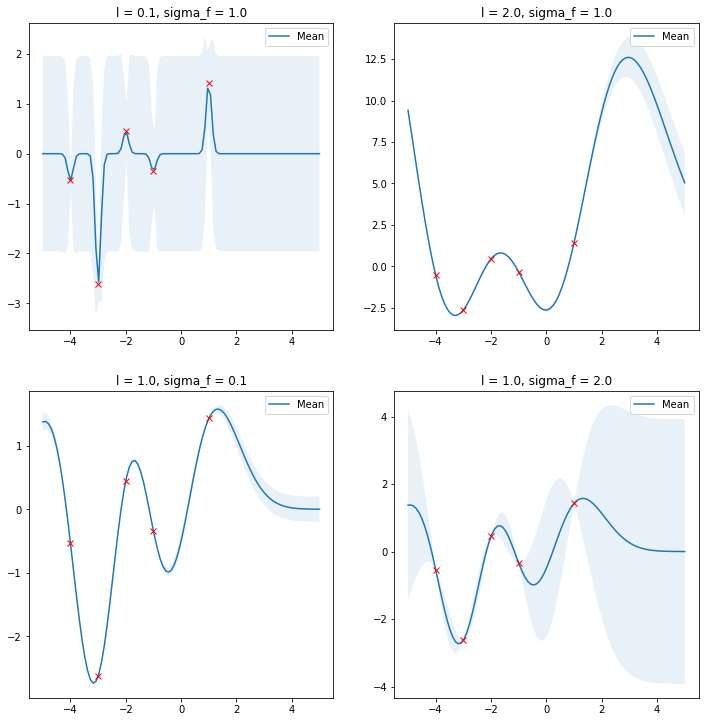

In [ ]:
params = [
    (0.1, 1.0),
    (2.0, 1.0),
    (1.0, 0.1),
    (1.0, 2.0)
]

plt.figure(figsize=(12, 5))

for i, (l, sigma_f) in enumerate(params):
    mu_s, cov_s = update_posterior(X_test, X_train, Y_train, l=l, 
                            sigma_f=sigma_f)
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}')
    plot_gp(mu_s, cov_s, X_test, X_train=X_train, Y_train=Y_train)

# Hyperparameter tuning

In [ ]:
from numpy.linalg import det
from scipy.optimize import minimize

# direct implementation, may be numerically unstable
def nll_direct(X_train, Y_train, noise):
    """
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train and given
    noise level.

    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.

    Returns:
        Minimization objective function.
    """
    Y_train = Y_train.ravel()
    
    def nll(theta):
        K = ise_kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        return 0.5 * Y_train.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi) + \
               0.5 * np.log(det(K))
        
    return nll

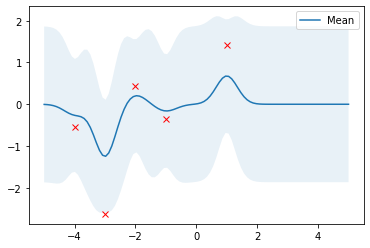

In [ ]:
# initialize at [1,1] and search for optimal values within between 1e-5 to infinity
res = minimize(nll_direct(X_train, Y_train, noise), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')
l_opt, sigma_f_opt = res.x
# compute posterior mean and covariance with optimized kernel parameters and plot the results
mu_s, cov_s = update_posterior(X_test, X_train, Y_train, l=l_opt, 
                               sigma_f=sigma_f_opt, sigma_y=noise)
plot_gp(mu_s, cov_s, X_test, X_train=X_train, Y_train=Y_train)

In [ ]:
from numpy.linalg import cholesky
from scipy.linalg import solve_triangular

# indirect implementation which is more numerically stable
def nll_stable(X_train, Y_train, noise):
    Y_train = Y_train.ravel()
    
    def nll(theta):
        K = ise_kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        L = cholesky(K)
        # solve the first system of equations
        m = solve_triangular(L, Y_train, lower=True)
        # solve the second system of equations
        alpha = solve_triangular(L.T, m, lower=False)
        
        return 0.5 * Y_train.dot(alpha) + \
               0.5 * len(X_train) * np.log(2*np.pi) + \
               np.sum(np.log(np.diagonal(L))) 
               
    return nll

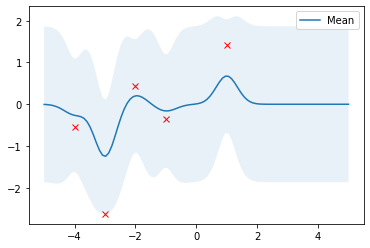

In [ ]:
# initialize at [1,1] and search for optimal values within between 1e-5 to infinity
res = minimize(nll_stable(X_train, Y_train, noise), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')
l_opt, sigma_f_opt = res.x
# compute posterior mean and covariance with optimized kernel parameters and plot the results
mu_s, cov_s = update_posterior(X_test, X_train, Y_train, l=l_opt, 
                               sigma_f=sigma_f_opt, sigma_y=noise)
plot_gp(mu_s, cov_s, X_test, X_train=X_train, Y_train=Y_train)